<a href="https://colab.research.google.com/github/git2101487/DeepLearning2022Late/blob/main/RNN%2BExample_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTMを使ったRNNを実装する

## ライブラリのimport

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense

In [3]:
# from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.layers import TimeDistributed

# データセット(imdb)の読み込み

In [4]:
from keras.datasets import imdb

### SVGの表示に必要なライブラリのimport

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

### Numpyなどのツールの読み込み

In [7]:
import numpy as np
from keras.utils import to_categorical, np_utils

### データ数、バッチ数など、各種定数を定義する

In [8]:
train_reviews = 5000
valid_reviews = 100
max_features = 5000
embedding_size = 256
step_size = 5
batch_size = 32
index_from = 2
rnn_units = 128
epochs = 2
word_index_prev = {'<PAD>':0, '<START>':1, '<UNK>':2}

## IMDBデータセットを読み込む

In [9]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, index_from=index_from)

17464789/17464789 [==============================] - 0s 0us/step


### 読み込んだデータを加工する(単語に関する情報を抜き出す)

In [10]:
word_index = {word:(index+index_from)
for word, index in imdb.get_word_index().items() if (index + index_from) < max_features}
word_index.update(word_index_prev)

1641221/1641221 [==============================] - 0s 0us/step


### 加工した単語情報から辞書を作成する

In [12]:
index_word = {index: word for word, index in word_index.items()}

## 文章を表示する関数を定義する

In [13]:
def print_sentence(sentence):
  for index in sentence:
    print(index_word[index], end=" ")
  # ループ終わり
  print()
# 関数定義終わり

### 定義した関数print_sentenceで学習用データの1行目を表示してみる

In [14]:
print_sentence(x_train[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

## 学習用のtrainデータを学習用とバリデーション検証用に分ける

In [15]:
# train_reviews = 5000
# valid_reviews = 100 にわける
# 学習用 5000件
data_train = [t for s in x_train[:train_reviews] for t in s]
# バリデーション用 100
data_valid = [t for s in x_train[train_reviews:train_reviews+valid_reviews] for t in s]

## バッチ処理のための関数を定義する

In [17]:
def batch_generator(data, batcf_size, step_size):
  seg_len = len(data) // batch_size
  steps_per_epoch = seg_len // step_size
  data_seg_list = np.asarray([data[int(i*seg_len):int((i+1)*seg_len)]
                              for i in range(batch_size)])
  i = 0
  while True:
    x = data_seg_list[:, int(i*step_size):int((i+1)*step_size)]
    y = np.asarray([to_categorical(
    data_seg_list[j, int(i*step_size+1):int((i+1)*step_size+1)],max_features)
    for j in range(batch_size)])
    yield x, y
    i += 1
    if i >= steps_per_epoch:
      i=0
    # if文終わり
  # while文終わり
# 関数def終わり

## 学習モデルを組み立てる

In [20]:
w = Input(shape=(step_size,), name='Input') # 入力層
x = Embedding(input_dim=max_features, output_dim=embedding_size, name='Enbedding')(w)
y = LSTM(units=rnn_units, return_sequences=True, dropout=0.5,recurrent_dropout=0.5, name='LSTM')(x)
w_next = TimeDistributed(Dense(units=max_features, activation='softmax', name='Dense'),name='TimeDistributed')(y)
# モデルのインスタンスを生成
model = Model(inputs=[w], outputs=[w_next])

### 生成したモデルオブジェクトの形をSVGで表示

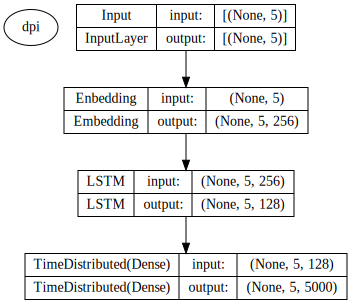

In [22]:
SVG(model_to_dot(model, show_shapes=True, dpi=None).create(prog='dot',format='svg'))

### モデルのコンパイル

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## 生成したモデルに学習させる(バッチごとに)

In [24]:
# バッチ処理用にデータセットを加工
gen_train = batch_generator(data_train, batch_size, step_size)
gen_valid = batch_generator(data_valid, batch_size, step_size)

In [25]:
# 各データのバッチごとのステップ数を学習時に指定するために算出
steps_per_epoch_train = len(data_train) / batch_size / step_size
steps_per_epoch_valid = len(data_valid) / batch_size / step_size

In [27]:
# バッチ処理ごとにデータを学習とバリデーションする
model.fit_generator(generator=gen_train, steps_per_epoch=steps_per_epoch_train,
                    epochs=epochs,
                    validation_data=gen_valid, validation_steps=steps_per_epoch_valid)

Epoch 1/2
   3/7619 [..............................] - ETA: 4:13 - loss: 5.3695 - accuracy: 0.1354

<ipython-input-27-b33d12095c70>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=gen_train, steps_per_epoch=steps_per_epoch_train,


7619/7619 [==============================] - 310s 41ms/step - loss: 5.4201 - accuracy: 0.1677 - val_loss: 5.3940 - val_accuracy: 0.1673
Epoch 2/2
7619/7619 [==============================] - 311s 41ms/step - loss: 5.5114 - accuracy: 0.1725 - val_loss: 5.5213 - val_accuracy: 0.1720


# 学習したモデルを使ってランダムに文章を作らせる

In [31]:
# 次に来る単語を選ぶ関数
def sample(preds, temperature=1.0):
  preds = np.log(preds) / temperature
  preds = np.exp(preds) / np.sum(np.exp(preds))
  choices = range(len(preds))
  return np.random.choice(choices, p=preds)
# 関数終わり

In [32]:
# ランダムに文章を生成する関数
def sample_sentences(num_sentences, sample_sent_len = 20):
  for x_test_i in x_test[:num_sentences]:
    x = np.zeros((1, step_size))
    sentence = x_test_i[:step_size]

    for i in range(sample_sent_len):
      for j, index in enumerate(sentence[-step_size:]):
        x[0, j] = index
      preds = model.predict(x)[0][-1]
      next_index = sample(preds)
      sentence.append(next_index)
    # ループ終わり
  print_sentence(sentence)

In [33]:
# ランダムに文章を抽出
sample_sentences(num_sentences=20, sample_sent_len=15)

1/1 [==============================] - 0s 19ms/step
<START> right so you have since the without the work in horror films from our where this is a night 
